In [1]:
!nvidia-smi

Fri Oct 18 11:42:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:5E:00.0 Off |                    0 |
| N/A   27C    P0             31W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import pandas as pd 
df = pd.read_table('/home/kbg32/project/complete_score_Mprops_1_2_smoothed_sasa_v2.txt')
df

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0     peptide       allele  \
0                 0             0           0  LSNSGKDVPK  HLA-A*11:01   
1                 1             1           1  TTLFHTFYEL  HLA-A*24:02   
2                 2             2           2   KFGDLTNNF  HLA-A*24:02   
3                 3             3           3   KLFESKAEL  HLA-A*02:01   
4                 4             4           4  KLFESKAELA  HLA-A*02:01   
...             ...           ...         ...         ...          ...   
24534         24534         24534       24535   DSKGRSYNL  HLA-B*08:01   
24535         24535         24535       24536   DSKKRSYNL  HLA-B*08:01   
24536         24536         24536       24537   TDLGQNLLY  HLA-A*01:01   
24537         24537         24537       24538  AVVSLLRLLK  HLA-A*11:01   
24538         24538         24538       24539   NIQTAINQV  HLA-A*02:01   

       immunogenicity  aliphathic_index     boman    charge   hphobic  ...  \
0                   0         68.000000  2.336000  0.976371  0.623781  ...   
1                   0         78.000000  0.352000 -0.783389  0.422806  ...   
2                   0         43.333333  2.033333 -0.023470  0.547654  ...   
3                   0         97.777778  1.498889 -0.021908  0.348054  ...   
4                   0         98.000000  1.168000 -0.021908  0.372761  ...   
...               ...               ...       ...       ...       ...  ...   
24534               1         43.333333  4.101111  0.975733  0.205675  ...   
24535               1         43.333333  4.822222  1.975574  0.317866  ...   
24536               1        130.000000  0.878889 -1.024105  0.415747  ...   
24537               1        224.000000 -0.570000  1.975733  0.604732  ...   
24538               1        130.000000  1.248889 -0.024105  0.568575  ...   

       Foreignness_Score  Dissimilarity_Score  quant_foreign  \
0                0.00000         0.000000e+00      -5.199338   
1                0.00000         0.000000e+00      -5.199338   
2                0.00000         0.000000e+00      -5.199338   
3                0.00000         1.465494e-14      -5.199338   
4                0.00000         0.000000e+00      -5.199338   
...                  ...                  ...            ...   
24534            0.00762         2.052913e-12       0.827130   
24535            0.99238         1.666419e-01       1.067571   
24536            1.00000         9.841214e-01       5.199338   
24537            0.00000         9.997602e-01      -5.199338   
24538            0.00000         2.263400e-07      -5.199338   

       smoothed_foreign  master_property_score    Mprop1    Mprop2  \
0             -5.119560               0.366501  0.179436  0.490884   
1             -5.074294               0.401047  0.330735  0.436979   
2             -4.979414               0.330519  0.192958  0.424324   
3             -4.832563               0.346405  0.266938  0.396085   
4             -4.639388               0.363109  0.271797  0.418384   
...                 ...                    ...       ...       ...   
24534          0.086094               0.387165  0.290392  0.432358   
24535         -0.377174               0.435194  0.298521  0.501794   
24536         -0.843474               0.360162  0.374864  0.329334   
24537         -1.233433               0.532929  0.502696  0.509585   
24538         -1.458242               0.389507  0.358522  0.387246   

                       combo   sasa_af  smoothed_af_sasa  
0      LSNSGKDVPKHLA-A*11:01  5.467838          5.576432  
1      TTLFHTFYELHLA-A*24:02  3.967922          5.572495  
2       KFGDLTNNFHLA-A*24:02  6.196591          5.564692  
3       KLFESKAELHLA-A*02:01  7.051576          5.552952  
4      KLFESKAELAHLA-A*02:01  7.206483          5.537300  
...                      ...       ...               ...  
24534   DSKGRSYNLHLA-B*08:01  4.905662          5.192546  
24535   DSKKRSYNLHLA-B*08:01  5.650996          5.184949  
24536   TDLGQNLLYHLA-A*01:01  4.722892  

In [2]:
import torch
import wandb
import yaml
from dgl.dataloading import GraphDataLoader

from data import ImmunoPredDataset, collate, SplitDataset
from models.mapping import model_map
from utils import Losses2, plot_losses
from infer import inference

config = "/home/kbg32/project/Immunopred/ImmunoPred/refactor/config.yaml"
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)


device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

learning_rate_a = cfg["learning_rate_a"]
learning_rate_b = cfg["learning_rate_b"]
num_epochs = cfg["num_epochs"]
batch_size = cfg["batch_size"]
#num_epochs = 5


torch.manual_seed(cfg["seed"])

generator = torch.Generator().manual_seed(cfg["seed"])

# Training loop
def train_model(model, train_loader, val_loader, optimizer, losses, experiment_name = ""):
    train_losses = []
    val_losses = []
    
    lowest_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for graph_data, sequence_data, target, peptide_property in train_loader:
            graph_data = graph_data.to(device)
            sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar, final_output = model(graph_data, sequence_data, peptide_property)

            loss = losses.regression_loss(recon_batch, sequence_data, mu, logvar, final_output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graph_data, sequence_data, target, peptide_property in val_loader:
                graph_data = graph_data.to(device)
                sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

                recon_batch, mu, logvar, final_output = model(graph_data, sequence_data, peptide_property)
                loss = losses.regression_loss(recon_batch,sequence_data, mu, logvar, final_output, target)
                val_loss += loss.item()

        if val_loss < lowest_val_loss:
            torch.save(model.state_dict(), experiment_name + ".pt")
            lowest_val_loss = val_loss

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        wandb.log({
            "pretrain_train_loss": train_loss, 
            "pretrain_val_loss": val_loss
        })

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# finetune with different dataset
def finetune_model(model, train_loader, val_loader, optimizer, losses, experiment_name = ""):
    train_losses = []
    val_losses = []
    
    lowest_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for graph_data, sequence_data, target, peptide_property in train_loader:

            graph_data = graph_data.to(device)
            sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar, final_output = model(graph_data, sequence_data, peptide_property)

            loss = losses.BCE_loss(recon_batch, sequence_data, mu, logvar, final_output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graph_data, sequence_data, target, peptide_property in val_loader:
                graph_data = graph_data.to(device)
                sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

                recon_batch, mu, logvar, final_output = model(graph_data, sequence_data, peptide_property)
                loss = losses.BCE_loss(recon_batch, sequence_data, mu, logvar, final_output, target)
                val_loss += loss.item()

        if val_loss < lowest_val_loss:
            torch.save(model.state_dict(), experiment_name + ".pt")
            lowest_val_loss = val_loss

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        wandb.log({
            "finetune_train_loss": train_loss, 
            "finetune_val_loss": val_loss
        })

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    return train_losses, val_losses

if __name__ == '__main__':

    wandb.init(
        # set the wandb project where this run will be logged
        project="ImmunoPred-Final-IEDB",
        entity="immunoteam",

        # track hyperparameters and run metadata
        config=cfg
    )

    ## Train Dataset
    dataset = ImmunoPredDataset(config, '/gpfs/gibbs/project/krishnaswamy_smita/kbg32/extracted_folder_FULL2/PyGs', 
                                '/home/kbg32/project/complete_score_Mprops_1_2_smoothed_sasa_v2.txt', 
                                '/home/kbg32/project/HLA_27_seqs_csv.csv')#, binary=False)
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.10, 0.10], generator)
    print(len(train_dataset), len(val_dataset), len(test_dataset))

    # Use this so that we do augmentations on just train dataset
    train_split_dataset = SplitDataset(train_dataset, "train", binary=False, full=cfg["full_sequence"])
    val_split_dataset = SplitDataset(val_dataset, "val", binary=False, full=cfg["full_sequence"])
    test_split_dataset = SplitDataset(test_dataset, "test", binary=False, full=cfg["full_sequence"])

    train_loader = GraphDataLoader(train_split_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)
    val_loader = GraphDataLoader(val_split_dataset, batch_size=batch_size, collate_fn=collate, shuffle=False)
    test_loader = GraphDataLoader(test_split_dataset, batch_size=batch_size, collate_fn=collate, shuffle=False)

    # input_dim = sequence length (11 for peptide, 283 for sequence) * embedding
    input_dim = 283 * 21 if cfg["full_sequence"] else 11 * 21
    model = model_map[cfg["model"]](vae_input_dim=input_dim, device=device)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_a)
    losses = Losses2(input_dim, dataset.class_weights, sequence=cfg["sequence_loss"])

    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, losses, experiment_name="train_model")
    # plot_losses(train_losses, val_losses)

    print("DONE PRE-TRAINING")

    ## Finetune Dataset
    model.load_trained("train_model.pt", new_head=True)

    # Use this so that we do augmentations on just train dataset
    train_split_dataset_b = SplitDataset(train_dataset, "train", binary=True, full=cfg["full_sequence"])
    val_split_dataset_b = SplitDataset(val_dataset, "val", binary=True, full=cfg["full_sequence"])
    test_split_dataset_b = SplitDataset(test_dataset, "test", binary=True, full=cfg["full_sequence"])

    train_loader_b = GraphDataLoader(train_split_dataset_b, batch_size=batch_size, collate_fn=collate, shuffle=True)
    val_loader_b = GraphDataLoader(val_split_dataset_b, batch_size=batch_size, collate_fn=collate, shuffle=False)
    test_loader_b = GraphDataLoader(test_split_dataset_b, batch_size=batch_size, collate_fn=collate, shuffle=False)

    optimizer_b = torch.optim.Adam(model.parameters(), lr=learning_rate_b, weight_decay=1e-6)
    train_losses, val_losses = finetune_model(model, train_loader_b, val_loader_b, optimizer_b, losses, experiment_name="finetune_model")
    # plot_losses(train_losses, val_losses)

    print("DONE FINE TUNING")

    model.load_trained("finetune_model.pt", new_head=False)
    
    accuracy, precision, recall, f1, roc_auc = inference(model, train_loader_b, device)
    wandb.log({
        'Train Accuracy': accuracy,
        'Train Precision': precision,
        'Train Recall': recall,
        'Train F1 Score': f1,
        'Train ROC AUC': roc_auc
    })

    accuracy, precision, recall, f1, roc_auc = inference(model, test_loader_b, device)
    
    wandb.log({
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1 Score': f1,
        'Test ROC AUC': roc_auc
    })

cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kevingivechian (immunoteam). Use `wandb login --relogin` to force relogin


Loading graphs: 100%|██████████| 24607/24607 [00:15<00:00, 1560.88it/s]


Loaded 24607 graphs.
new sequence table size: 23339, removed 1200
new graph list size: 23339, removed 0
peptide
Counter({0: 18583, 1: 4756})
dupes 0 0
Preprocess Complete
18672 2334 2333
Epoch 1, Train Loss: 0.4597, Val Loss: 0.3876
Epoch 2, Train Loss: 0.3613, Val Loss: 0.3501
Epoch 3, Train Loss: 0.3373, Val Loss: 0.3003
Epoch 4, Train Loss: 0.2863, Val Loss: 0.2522
Epoch 5, Train Loss: 0.2589, Val Loss: 0.2478
Epoch 6, Train Loss: 0.2372, Val Loss: 0.2123
Epoch 7, Train Loss: 0.2126, Val Loss: 0.1920
Epoch 8, Train Loss: 0.1970, Val Loss: 0.1799
Epoch 9, Train Loss: 0.1903, Val Loss: 0.1683
Epoch 10, Train Loss: 0.1877, Val Loss: 0.1651
Epoch 11, Train Loss: 0.1774, Val Loss: 0.1917
Epoch 12, Train Loss: 0.1746, Val Loss: 0.1573
Epoch 13, Train Loss: 0.1611, Val Loss: 0.1489
Epoch 14, Train Loss: 0.1602, Val Loss: 0.1472
Epoch 15, Train Loss: 0.1477, Val Loss: 0.1213
Epoch 16, Train Loss: 0.1340, Val Loss: 0.1163
Epoch 17, Train Loss: 0.1382, Val Loss: 0.1151
Epoch 18, Train Loss: 0

In [7]:
def mean_PPVn(values_true, values_pred, topk=None):
    '''
    NOTE: I cross-checked with the official implementation of
    "Deep neural networks predict class I major histocompatibility complex epitope presentation and
    transfer learn neoepitope immunogenicity"

    https://github.com/KarchinLab/bigmhc/blob/6d894cb359fab57b7ccdd7b688a1ac15d44063bd/nb/makefigs.ipynb#L156
    '''

    assert len(values_true) == len(values_pred)

    # Sorting by score in descending order
    sorting_idx = np.argsort(values_pred)[::-1]
    values_true = values_true[sorting_idx]

    # Calculate cumulative true positives
    cum_true_positives = np.cumsum(values_true)

    # Total possible positives in top n
    total_predictions = np.arange(1, len(values_true) + 1)

    # Calculating PPVn
    ppvn = cum_true_positives / total_predictions

    # Mean PPVn across all n
    num_positives = int(values_true.sum())

    if topk is None:
        mean_ppvn = np.mean(ppvn[:num_positives])
    elif topk >= len(ppvn[:num_positives]):
        mean_ppvn = np.mean(ppvn[:num_positives])
        print(f"`mean_PPVn`: topk ({topk}) bigger than number of positive samples ({num_positives}).")
    else:
        mean_ppvn = np.mean(ppvn[:num_positives][:topk])

    return mean_ppvn

In [8]:
def inference_with_mean_PPVn(model, data_loader, device):
    model.eval()
    true_targets = []
    predicted_probs = []  # Store raw probabilities for ROC AUC and PR AUC calculations
    predicted_labels = []  # Store binary predictions for other metrics

    with torch.no_grad():
        for graph_data, sequence_data, target, peptide_property in data_loader:
            graph_data = graph_data.to(device)
            sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

            _, _, _, final_output = model(graph_data, sequence_data, peptide_property)

            # Convert to probabilities
            probs = torch.sigmoid(final_output).squeeze()

            # Handle the case where probs is a scalar
            if probs.ndim == 0:
                probs = probs.unsqueeze(0)  # Make it a 1-element tensor

            probs = probs.cpu().numpy()

            # Convert probabilities to binary predictions
            predicted = np.round(probs)

            true_targets.extend(target.cpu().numpy())
            predicted_probs.extend(probs.tolist())  # Convert to list before extending
            predicted_labels.extend(predicted)

    # Calculate metrics
    true_targets = np.array(true_targets)
    predicted_probs = np.array(predicted_probs)
    predicted_labels = np.array(predicted_labels)

    accuracy = accuracy_score(true_targets, predicted_labels)
    precision = precision_score(true_targets, predicted_labels)
    recall = recall_score(true_targets, predicted_labels)
    f1 = f1_score(true_targets, predicted_labels)
    roc_auc = roc_auc_score(true_targets, predicted_probs)

    # Calculate precision-recall curve and PR AUC
    precision_curve, recall_curve, _ = precision_recall_curve(true_targets, predicted_probs)
    pr_auc = auc(recall_curve, precision_curve)  # Calculate the area under the curve

    # Calculate mean_PPVn
    mean_ppvn_value = mean_PPVn(true_targets, predicted_probs)

    # Print metrics
    print('metrics')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'PR AUC: {pr_auc:.4f}')  # Print PR AUC
    print(f'Mean PPVn: {mean_ppvn_value:.4f}')  # Print Mean PPVn

    return accuracy, precision, recall, f1, roc_auc, pr_auc, mean_ppvn_value


In [11]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc

def inference(model, data_loader, device):
    model.eval()
    true_targets = []
    predicted_probs = []  # Store raw probabilities for ROC AUC and PR AUC calculations
    predicted_labels = []  # Store binary predictions for other metrics

    with torch.no_grad():
        for graph_data, sequence_data, target, peptide_property in data_loader:
            graph_data = graph_data.to(device)
            sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

            _, _, _, final_output = model(graph_data, sequence_data, peptide_property)

            # Convert to probabilities
            probs = torch.sigmoid(final_output).squeeze()

            # Handle the case where probs is a scalar
            if probs.ndim == 0:
                probs = probs.unsqueeze(0)  # Make it a 1-element tensor

            probs = probs.cpu().numpy()

            # Convert probabilities to binary predictions
            predicted = np.round(probs)

            true_targets.extend(target.cpu().numpy())
            predicted_probs.extend(probs.tolist())  # Convert to list before extending
            predicted_labels.extend(predicted)

    # Calculate metrics
    true_targets = np.array(true_targets)
    predicted_probs = np.array(predicted_probs)
    predicted_labels = np.array(predicted_labels)

    accuracy = accuracy_score(true_targets, predicted_labels)
    precision = precision_score(true_targets, predicted_labels)
    recall = recall_score(true_targets, predicted_labels)
    f1 = f1_score(true_targets, predicted_labels)
    roc_auc = roc_auc_score(true_targets, predicted_probs)

    # Calculate precision-recall curve and PR AUC
    precision_curve, recall_curve, _ = precision_recall_curve(true_targets, predicted_probs)
    pr_auc = auc(recall_curve, precision_curve)  # Calculate the area under the curve

    print('metrics')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'PR AUC: {pr_auc:.4f}')  # Print PR AUC

    return accuracy, precision, recall, f1, roc_auc, pr_auc


In [15]:
accuracy, precision, recall, f1, roc_auc, pr_auc,mean_ppvn_value  = inference_with_mean_PPVn(model, test_loader_b, device)

metrics
Accuracy: 0.8341
Precision: 0.5825
Recall: 0.7134
F1 Score: 0.6413
ROC AUC: 0.8817
PR AUC: 0.7098
Mean PPVn: 0.8114


In [4]:
trained_model = model 

# Get attention weights 

In [7]:
attention_weights_list = []

with torch.no_grad():
    for graph_data, sequence_data, target, peptide_property in test_loader_b:
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

        attention_weights_n, _, _, final_output = trained_model(graph_data, sequence_data, peptide_property, return_attention = True)
        attention_weights_list.append(attention_weights_n)
        print(attention_weights_n.shape)

torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([128, 8, 190, 190])
torch.Size([44, 8, 190, 190])


# Get embeddings

In [28]:
embeddings = []
true_targets = []
predicted_targets = []
predicted_targets_probs = [] 
probs_raw = []

with torch.no_grad():
    for graph_data, sequence_data, target, peptide_property in train_loader_b:
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

        emb, _, _, final_output = model(graph_data, sequence_data, peptide_property, return_embedding = True)
        embeddings.append(emb.cpu().numpy())
        
        
        
        _, _, _, final_output = model(graph_data, sequence_data, peptide_property)
        
        probs = torch.sigmoid(final_output).squeeze()
        
        probs_raw.append(probs.cpu())
        
        probs = np.round(probs.cpu())

        # Store true targets and predicted targets
        true_targets.extend(target.cpu().numpy())
        predicted_targets.extend(final_output.cpu().numpy().flatten())
        predicted_targets_probs.extend(probs.cpu().numpy().flatten())

        print(embeddings)
        
        
# Convert lists to arrays for plotting
true_targets = np.array(true_targets)
predicted_targets = np.array(predicted_targets)
#predicted_targets_raw = np.array(probs_raw)
predicted_targets_probs = np.array(predicted_targets_probs)
embeddings2 = np.concatenate(embeddings)

[array([[ 66.20559   ,  66.113075  , -36.917675  , ...,  -1.2191141 ,
          0.302848  ,   0.4740979 ],
       [ 53.671486  ,  54.17892   , -30.560339  , ...,  -0.23731005,
          0.44697422,   0.49481162],
       [ 71.057     ,  70.223595  , -38.33199   , ...,  -0.5520117 ,
          0.23301797,   0.49624923],
       ...,
       [ 66.46672   ,  66.42407   , -37.171642  , ...,  -0.08206579,
          0.37566838,   0.5264483 ],
       [ 78.855034  ,  77.95263   , -43.110474  , ...,  -0.30103186,
          0.2675491 ,   0.50303125],
       [ 66.62342   ,  66.357895  , -36.836765  , ...,  -0.1627852 ,
          0.39849544,   0.5797116 ]], dtype=float32)]
[array([[ 66.20559   ,  66.113075  , -36.917675  , ...,  -1.2191141 ,
          0.302848  ,   0.4740979 ],
       [ 53.671486  ,  54.17892   , -30.560339  , ...,  -0.23731005,
          0.44697422,   0.49481162],
       [ 71.057     ,  70.223595  , -38.33199   , ...,  -0.5520117 ,
          0.23301797,   0.49624923],
       ...,
   

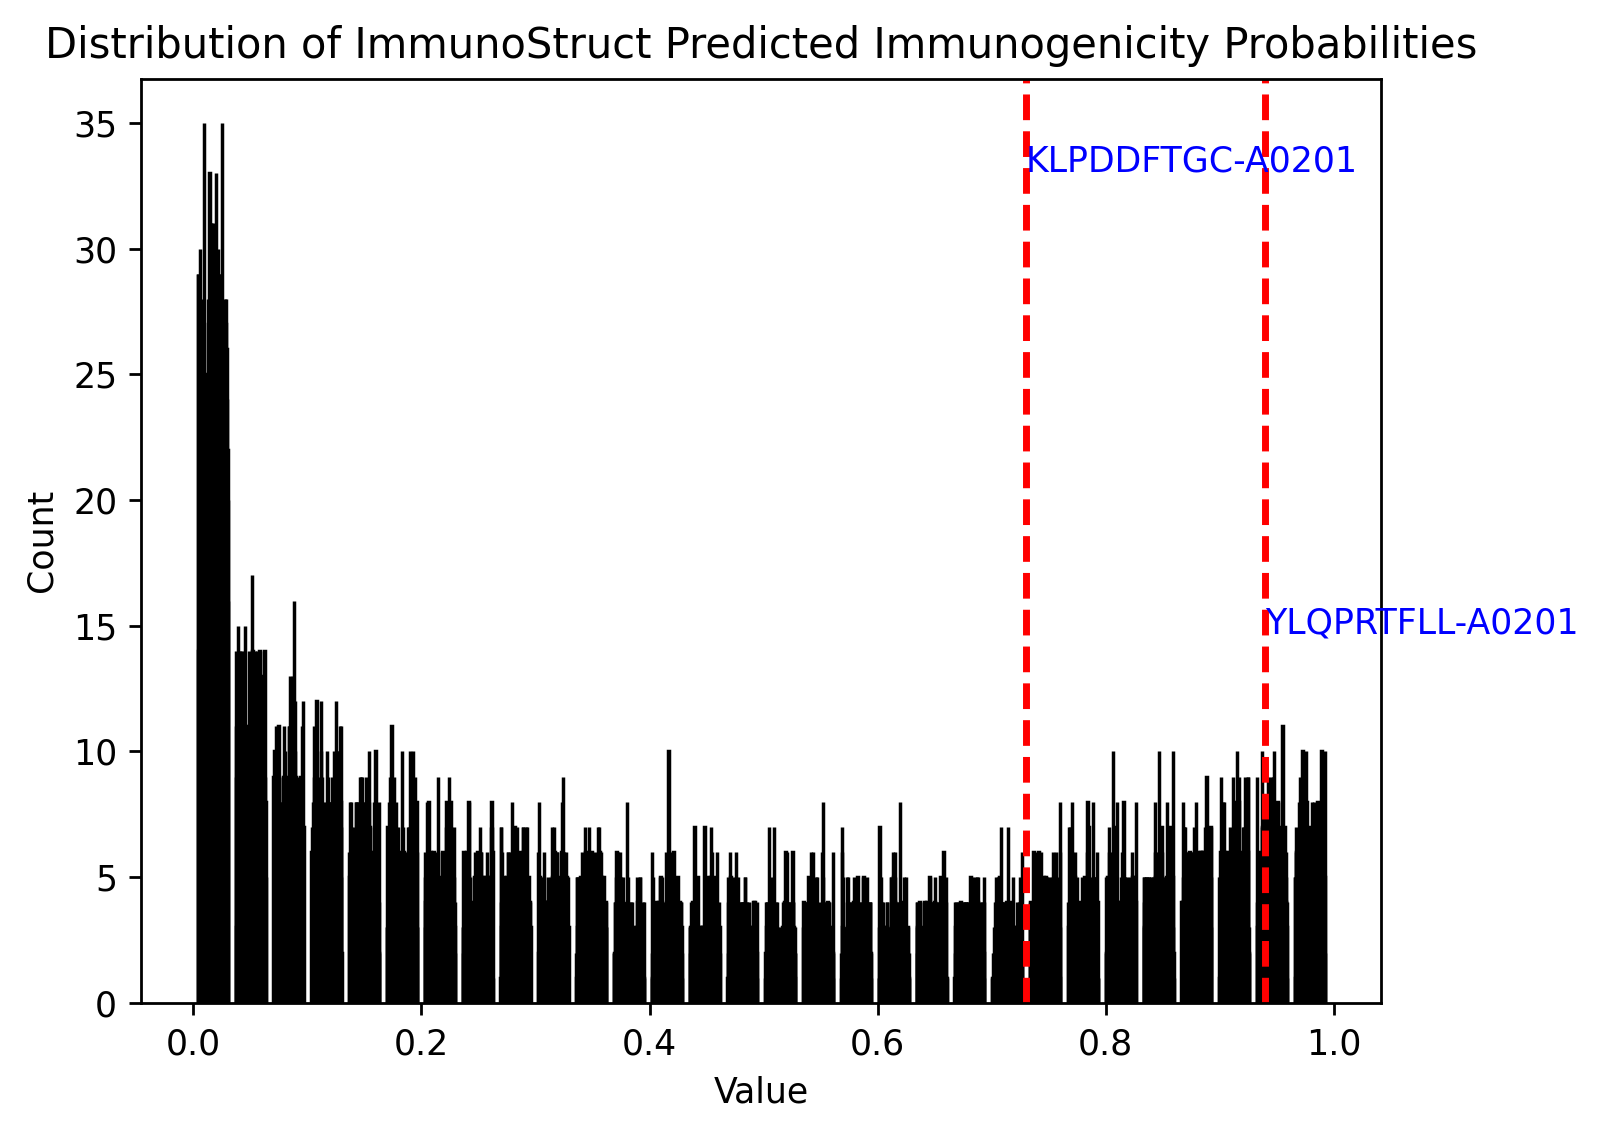

In [43]:
numbers = probs_raw


import matplotlib.pyplot as plt


# Create a figure with a higher DPI (e.g., 200)
plt.figure(dpi=250)
# Create a histogram to visualize the distribution
plt.hist(numbers, bins=30, edgecolor='black')

# Add titles and labels
plt.title('Distribution of ImmunoStruct Predicted Immunogenicity Probabilities')
plt.xlabel('Value')
plt.ylabel('Count')

# Add a red vertical line at 0.73
plt.axvline(x=0.73, color='red', linestyle='--', linewidth=2, label='KLPDDFTGC-A0201')
plt.axvline(x=0.94, color='red', linestyle='--', linewidth=2, label='KLPDDFTGC-A0201')

# Add a label for the red line
plt.text(0.73, plt.ylim()[1] * 0.9, 'KLPDDFTGC-A0201', color='blue', ha='left')

# Add a label for the red line
plt.text(0.94, plt.ylim()[1] * 0.4, 'YLQPRTFLL-A0201', color='blue', ha='left')





# Display the plot
plt.show()


In [9]:
import pandas as pd 
embeddings3 = pd.DataFrame(embeddings2)
embeddings3 = np.array(embeddings3)
embeddings3

array([[ 59.09073   ,  59.79824   , -34.202835  , ...,  -0.7154057 ,
          0.46567148,   0.3406127 ],
       [ 71.69064   ,  71.35877   , -39.687325  , ...,  -0.23879465,
          0.34676135,   0.35915586],
       [ 73.13339   ,  72.84316   , -40.78195   , ...,  -0.1833351 ,
          0.32056227,   0.30781883],
       ...,
       [ 62.458424  ,  62.777596  , -35.877537  , ...,  -0.7974324 ,
          0.38354188,   0.4055622 ],
       [ 73.65558   ,  73.42101   , -41.34968   , ...,  -0.83456475,
          0.5170258 ,   0.44318405],
       [ 64.00369   ,  63.92222   , -35.538643  , ...,  -0.79141873,
          0.2993053 ,   0.40744194]], dtype=float32)

In [10]:
pd.DataFrame(embeddings3)

0          1          2          3          4          5   \
0      59.090729  59.798241 -34.202835  21.626699  19.257154 -17.955853   
1      71.690643  71.358772 -39.687325  25.353285  22.177202 -22.247818   
2      73.133392  72.843163 -40.781952  26.157381  22.898266 -22.513697   
3      59.218681  59.978149 -34.415745  21.749887  19.370461 -17.903677   
4      53.168514  53.738026 -30.370825  19.113153  17.200674 -16.719820   
...          ...        ...        ...        ...        ...        ...   
16333  76.627747  76.948357 -44.260197  28.140785  24.654467 -22.565531   
16334  66.001534  65.973518 -36.949306  23.775421  20.730116 -20.588980   
16335  62.458424  62.777596 -35.877537  22.610445  20.121471 -18.781347   
16336  73.655579  73.421013 -41.349682  26.224163  23.085352 -22.395439   
16337  64.003693  63.922218 -35.538643  22.689196  19.962996 -20.046684   

              6          7          8          9   ...        88        89  \
0      16.731945  67.456940  21.805740  20.506571  ...  0.164807  0.060337   
1      20.571529  79.130058  25.452868  24.688408  ... -0.562609  0.479117   
2      20.877211  81.339714  26.191481  25.291790  ... -0.822965  0.313069   
3      16.731874  67.822006  21.902901  20.554379  ... -0.070882 -0.408799   
4      15.313243  59.491570  19.344297  18.616827  ... -0.085949 -0.474636   
...          ...        ...        ...        ...  ...       ...       ...   
16333  21.446098  87.835022  28.030197  26.371870  ... -0.583718  0.430374   
16334  18.847303  73.498497  23.812124  23.089787  ... -0.893002 -0.061256   
16335  17.643753  70.693336  22.748579  21.494650  ... -0.160872  0.028027   
16336  21.023794  82.110962  26.239643  25.286339  ...  0.341173 -0.961368   
16337  18.408421  70.665390  22.880505  22.160532  ... -0.747738  0.206818   

             90        91        92        93        94        95        96  \
0     -0.725744 -0.253712 -0.279094 -0.007130 -0.521858 -0.715406  0.465671   
1     -0.566907  0.368318  0.824878  0.338792 -0.852890 -0.238795  0.346761   
2     -0.545079 -0.459894  0.162695  0.171556 -0.763235 -0.183335  0.320562   
3     -0.882986  0.116333 -0.640807 -0.260938 -0.514243 -0.525177  0.389010   
4      0.180231 -0.796394  0.375269 -0.447147 -0.444320 -0.877280  0.427412   
...         ...       ...       ...       ...       ...       ...       ...   
16333 -0.920649  0.168808  0.948216  0.424027 -1.395691  0.020085  0.430142   
16334  0.109771  0.472700  0.099904 -0.005528 -0.368188  0.081751  0.284111   
16335 -0.198428 -0.291560 -0.397240 -0.008001 -0.426887 -0.797432  0.383542   
16336  0.316819  0.490681 -0.487559 -0.946016 -0.111320 -0.834565  0.517026   
16337 -0.971246 -0.226488  0.651665  0.396528 -0.793695 -0.791419  0.299305   

             97  
0      0.340613  
1      0.359156  
2      0.307819  
3      0.422309  
4      0.534779  
...         ...  
16333  0.538562  
16334  0.459360  
16335  0.405562  
16336  0.443184  
16337  0.407442  

[16338 rows x 98 columns]

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import phate



# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings3)


#phate_op = phate.PHATE(n_components=2)
#pca_result = phate_op.fit_transform(embeddings3)

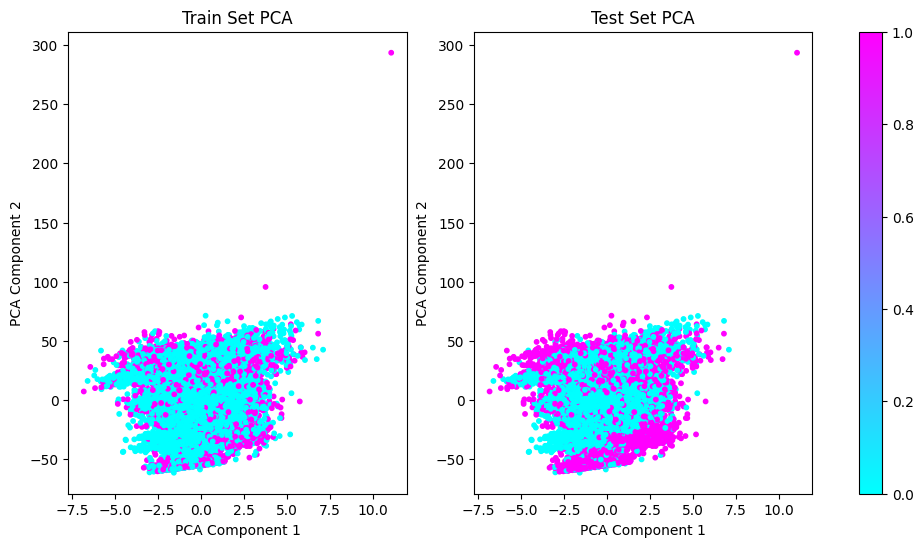

In [12]:





fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train set PCA plot


scatter = axes[0].scatter(pca_result[:, 1], pca_result[:, 0], c=true_targets, cmap='cool', s=10)
axes[0].set_title('Train Set PCA')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Test set PCA plot
axes[1].scatter(pca_result[:, 1], pca_result[:, 0], c=predicted_targets_probs, cmap='cool', s=10)
axes[1].set_title('Test Set PCA')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Colorbar
fig.colorbar(scatter, ax=axes, orientation='vertical')

plt.show()

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings3)



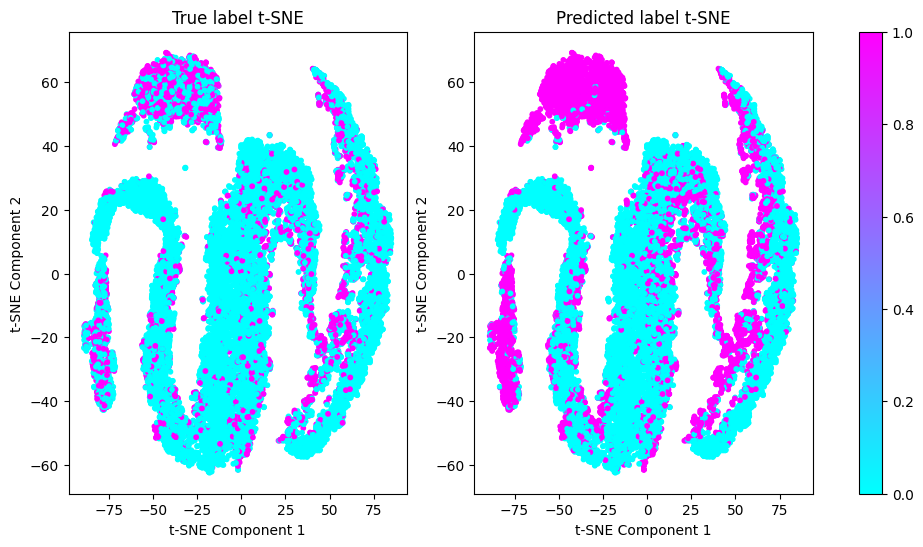

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train set t-SNE plot
scatter = axes[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=true_targets, cmap='cool', s=10)
axes[0].set_title('True label t-SNE')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Test set t-SNE plot
axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=predicted_targets_probs, cmap='cool', s=10)
axes[1].set_title('Predicted label t-SNE')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

# Colorbar
fig.colorbar(scatter, ax=axes, orientation='vertical')

plt.show()

In [15]:
import matplotlib.pyplot as plt
import phate


# Adjust PHATE parameters for more separation
phate_operator = phate.PHATE(
    n_components=2,
    knn=30,           # Increased to capture more global structure
    t=100,            # Increased diffusion time for better separation
    gamma=0.75,       # Adjusted to balance local and global structure
    n_pca=100,        # Increased to potentially capture more variance
    random_state=42
)



# Adjust PHATE parameters for more separation
phate_operator = phate.PHATE(
    n_components=2)


phate_result = phate_operator.fit_transform(embeddings3)



Calculating PHATE...
  Running PHATE on 16338 observations and 98 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 10.68 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 10.80 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.86 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.28 seconds.
  Calculated landmark operator in 6.93 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 2.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.68 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.57 seconds.
Calculated PHATE in 24.18 seconds.


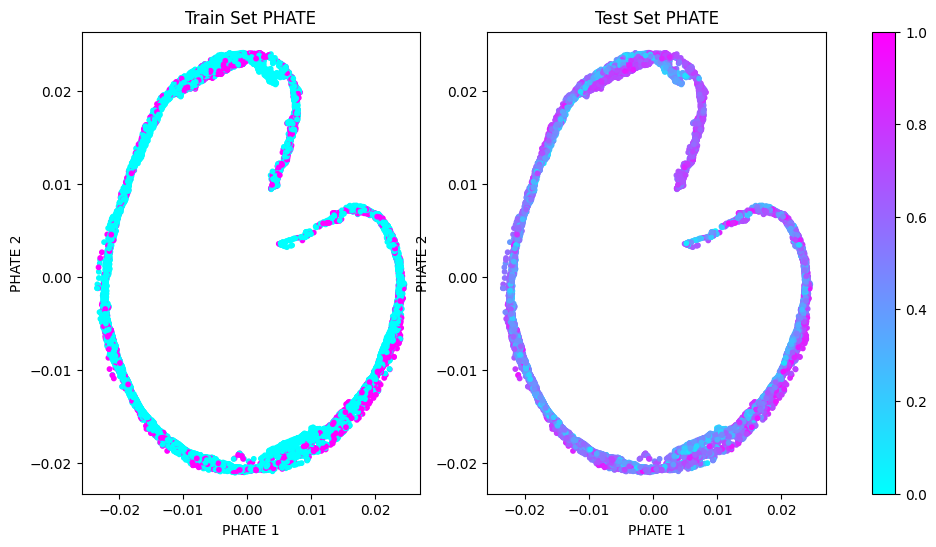

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train set PHATE plot
scatter = axes[0].scatter(phate_result[:, 0], phate_result[:, 1], c=true_targets, cmap='cool', s=10)
axes[0].set_title('Train Set PHATE')
axes[0].set_xlabel('PHATE 1')
axes[0].set_ylabel('PHATE 2')

# Test set PHATE plot
axes[1].scatter(phate_result[:, 0], phate_result[:, 1], c=predicted_targets, cmap='cool', s=10)
axes[1].set_title('Test Set PHATE')
axes[1].set_xlabel('PHATE 1')
axes[1].set_ylabel('PHATE 2')

# Colorbar
fig.colorbar(scatter, ax=axes, orientation='vertical')

plt.show()

In [24]:
import umap
import matplotlib.pyplot as plt

# Create and fit UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
umap_result = umap_reducer.fit_transform(embeddings3)

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Increased figure size for better visibility

# Train set UMAP plot
scatter = axes[0].scatter(umap_result[:, 0], umap_result[:, 1], c=true_targets, cmap='coolwarm', s=5, alpha=0.7)
axes[0].set_title('Train Set UMAP', fontsize=16)
axes[0].set_xlabel('UMAP 1', fontsize=14)
axes[0].set_ylabel('UMAP 2', fontsize=14)

# Test set UMAP plot
axes[1].scatter(umap_result[:, 0], umap_result[:, 1], c=predicted_targets, cmap='coolwarm', s=5, alpha=0.7)
axes[1].set_title('Test Set UMAP', fontsize=16)
axes[1].set_xlabel('UMAP 1', fontsize=14)
axes[1].set_ylabel('UMAP 2', fontsize=14)

# Colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', pad=0.01)
cbar.set_label('Target Values', fontsize=14)

plt.tight_layout()
plt.show()

/gpfs/gibbs/project/krishnaswamy_smita/kbg32/conda_envs/chem_relso_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/gibbs/project/krishnaswamy_smita/kbg32/conda_envs/chem_relso_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(

KeyboardInterrupt: 

In [ ]:
attention_weights_list[0][0].shape

In [ ]:
import torch
import pandas as pd

# Initialize a list to store the averaged attention weights
averaged_attention_weights_list = []

with torch.no_grad():
    for graph_data, sequence_data, target, peptide_property in test_loader_b:
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)

        # Get the attention weights from the model
        attention_weights_n, _, _, final_output = trained_model(graph_data, sequence_data, peptide_property, return_attention=True)

        # Average the attention heads
        averaged_attention_weights = attention_weights_n.mean(dim=1)  # Average across the head dimension
        averaged_attention_weights_list.append(averaged_attention_weights.cpu().numpy())

        print(f"Averaged attention shape: {averaged_attention_weights.shape}")

# Assuming you want to visualize the first set of averaged attention weights
averaged_attention_weights_df = pd.DataFrame(averaged_attention_weights_list[0][0])

# Display the dataframe
print(averaged_attention_weights_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(averaged_attention_weights_df, cmap='viridis', cbar=True, square=True)

# Add labels and a title
plt.title('Averaged Attention Weights Heatmap')
plt.xlabel('Amino Acid Position')
plt.ylabel('Amino Acid Position')

# Display the heatmap
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi = 350)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each attention head
for head_idx in range(8):
    # Extract the attention weights for the current head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Convert to a DataFrame for easy visualization
    individual_attention_weights_df = pd.DataFrame(individual_attention_weights)
    
    # Create the heatmap on the corresponding subplot
    sns.heatmap(individual_attention_weights_df, cmap='viridis', cbar=True, square=True, ax=axes[head_idx])
    
    # Add a title to each subplot
    axes[head_idx].set_title(f'Attention Head {head_idx + 1}')
    axes[head_idx].set_xlabel('Amino Acid Position')
    axes[head_idx].set_ylabel('Amino Acid Position')

# Adjust layout for better spacing
plt.tight_layout()

# Display the entire grid of heatmaps
plt.show()


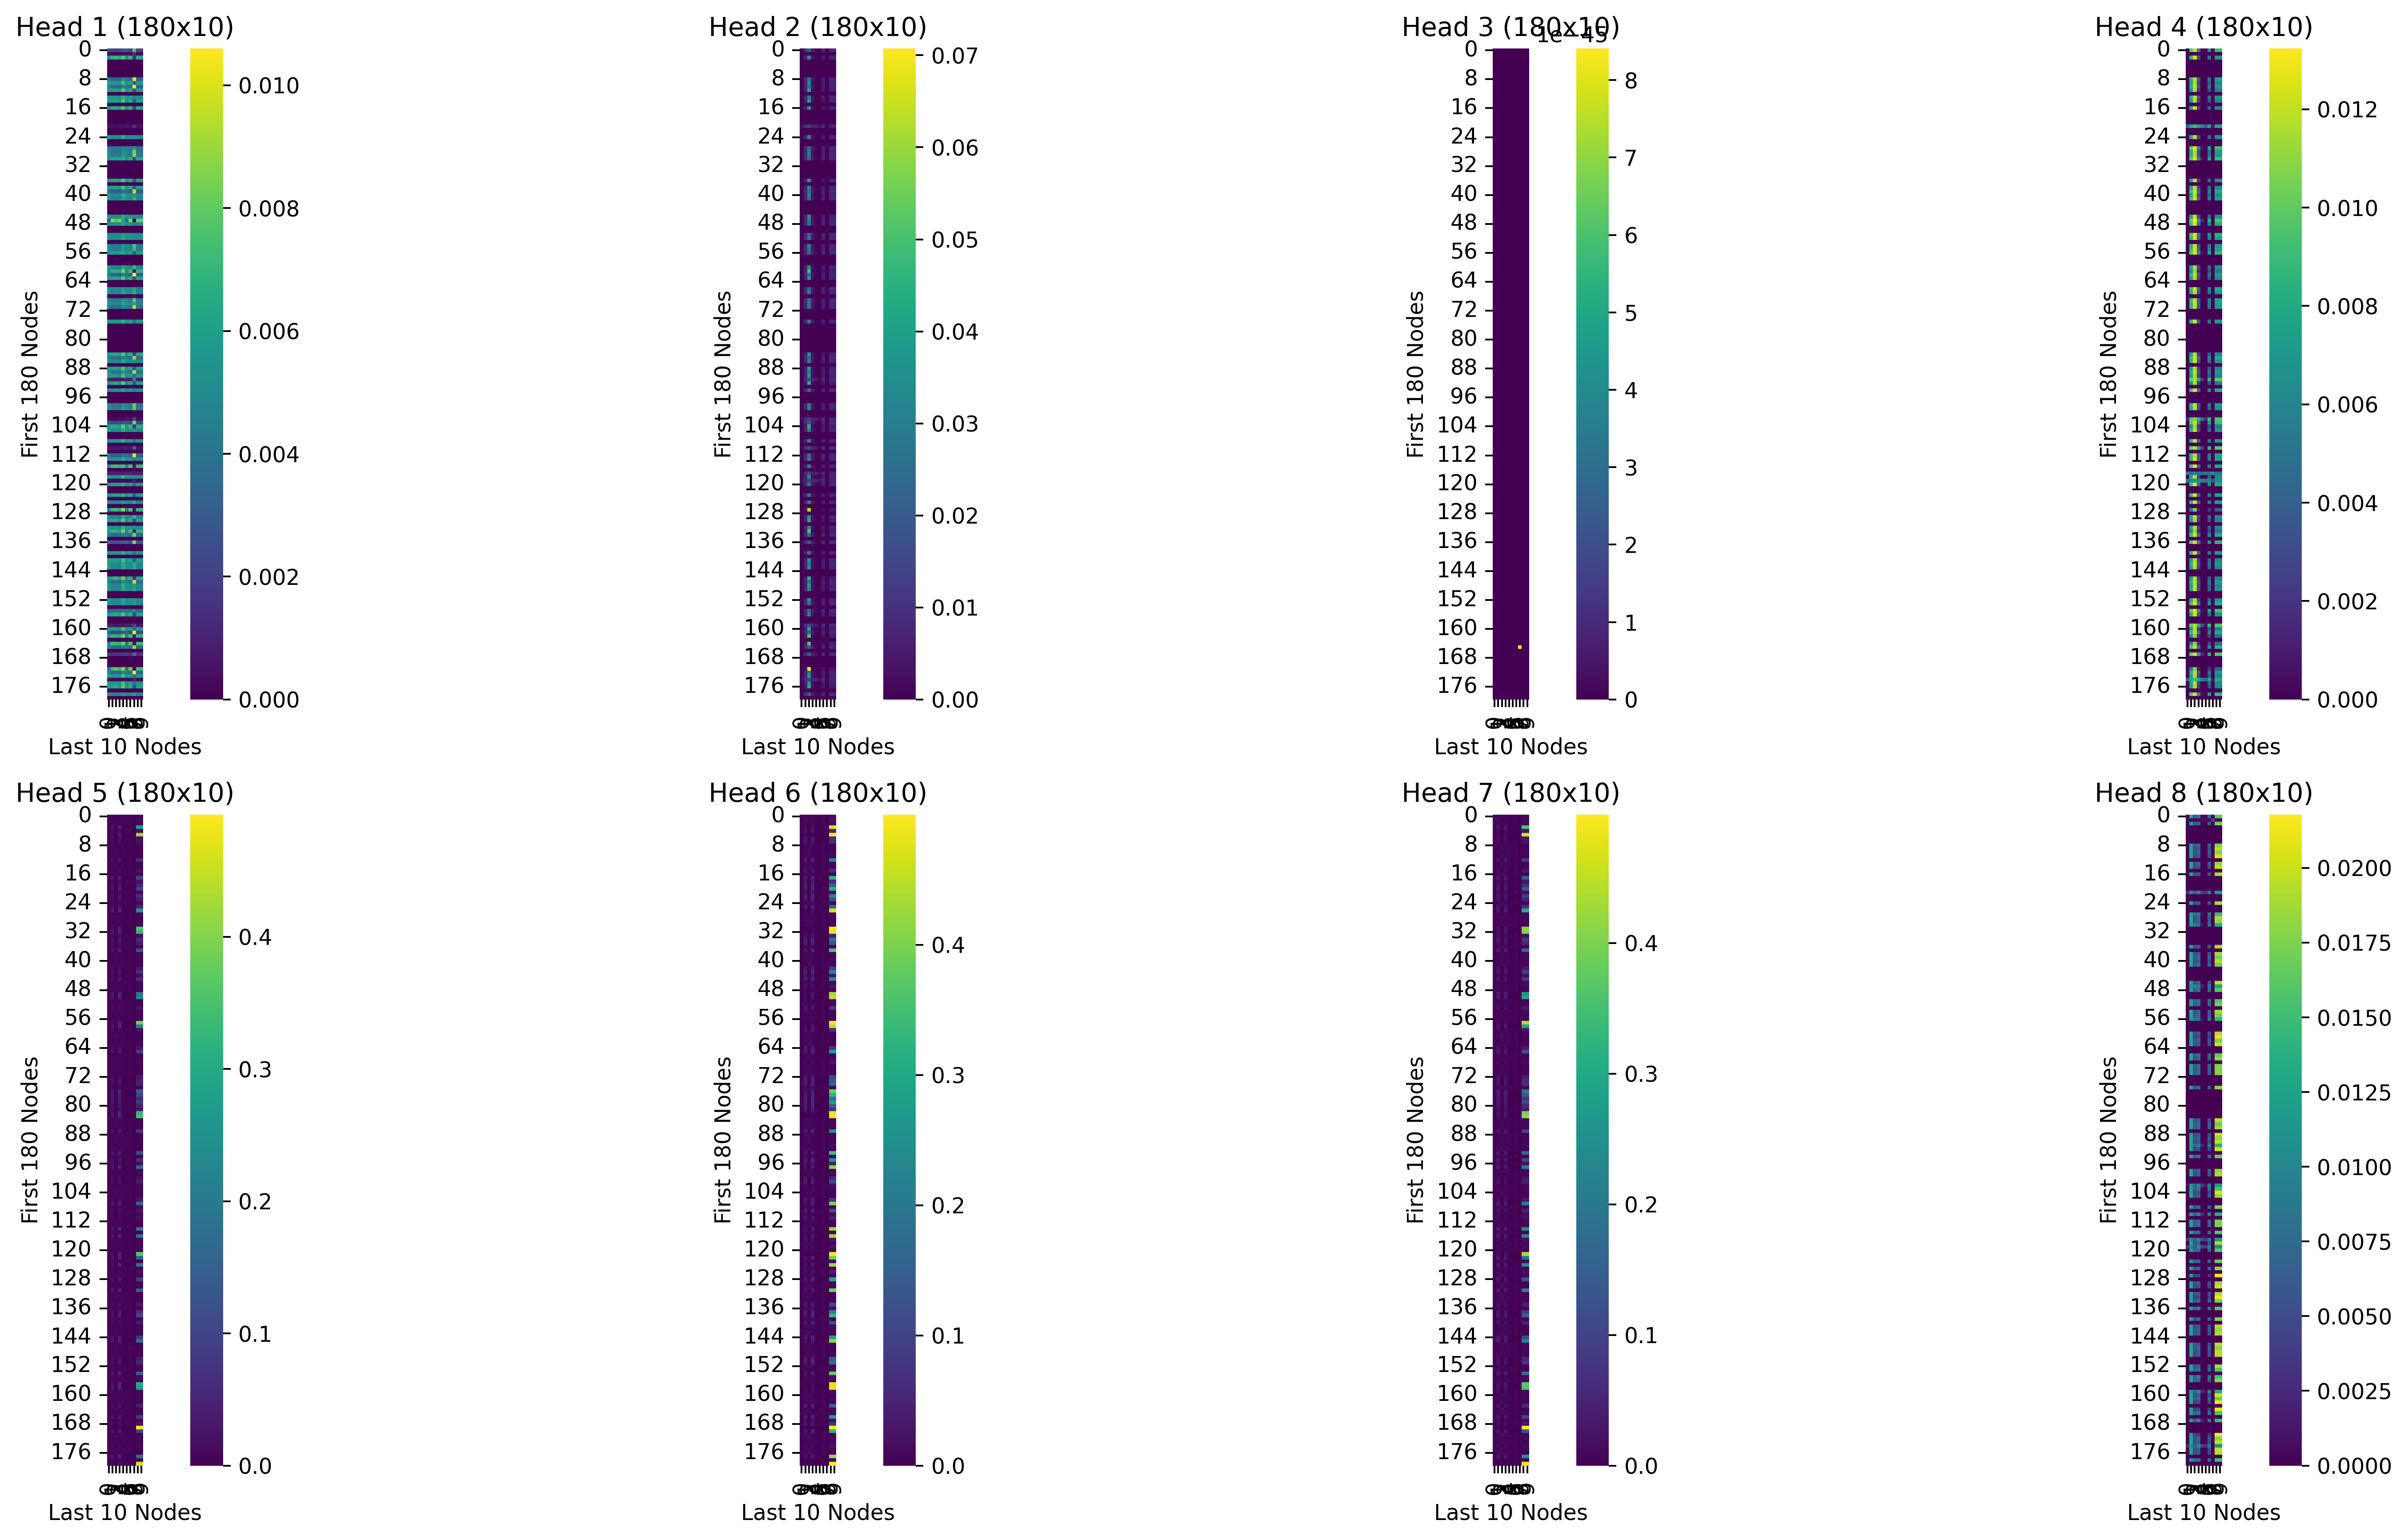

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10),dpi = 350)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each attention head
for head_idx in range(8):
    # Extract the attention weights for the current head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Convert to a DataFrame for easy visualization
    sliced_attention_weights_df = pd.DataFrame(sliced_attention_weights)
    
    # Create the heatmap on the corresponding subplot
    sns.heatmap(sliced_attention_weights_df, cmap='viridis', cbar=True, square=True, ax=axes[head_idx])
    
    # Add a title to each subplot
    axes[head_idx].set_title(f'Head {head_idx + 1} (180x10)')
    axes[head_idx].set_xlabel('Last 10 Nodes')
    axes[head_idx].set_ylabel('First 180 Nodes')

# Adjust layout for better spacing
plt.tight_layout()

# Display the entire grid of heatmaps
plt.show()
 

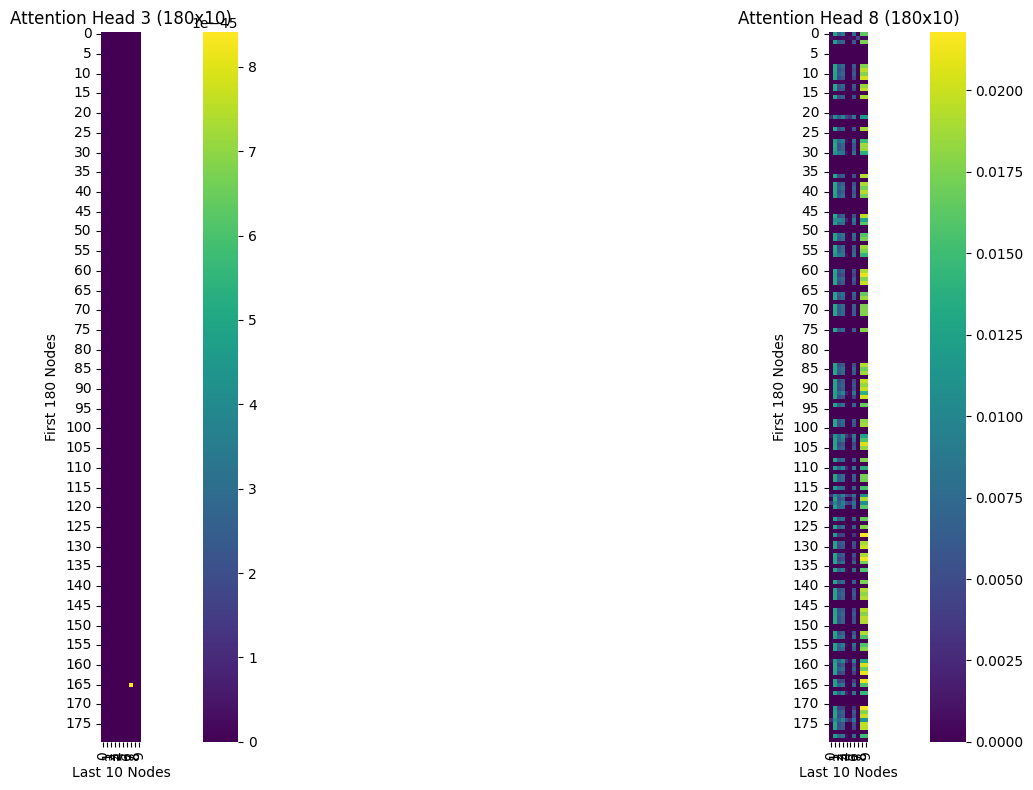

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1x2 grid)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Attention head indices we want to plot
head_indices = [2, 7]  # 4th and 8th heads (0-indexed, so 3 and 7)

for i, head_idx in enumerate(head_indices):
    # Extract the attention weights for the selected head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Convert to a DataFrame for easy visualization
    sliced_attention_weights_df = pd.DataFrame(sliced_attention_weights)
    
    # Create the heatmap on the corresponding subplot
    sns.heatmap(sliced_attention_weights_df, cmap='viridis', cbar=True, square=True, ax=axes[i])
    
    # Add a title to each subplot
    axes[i].set_title(f'Attention Head {head_idx + 1} (180x10)')
    axes[i].set_xlabel('Last 10 Nodes')
    axes[i].set_ylabel('First 180 Nodes')

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmaps
plt.show()



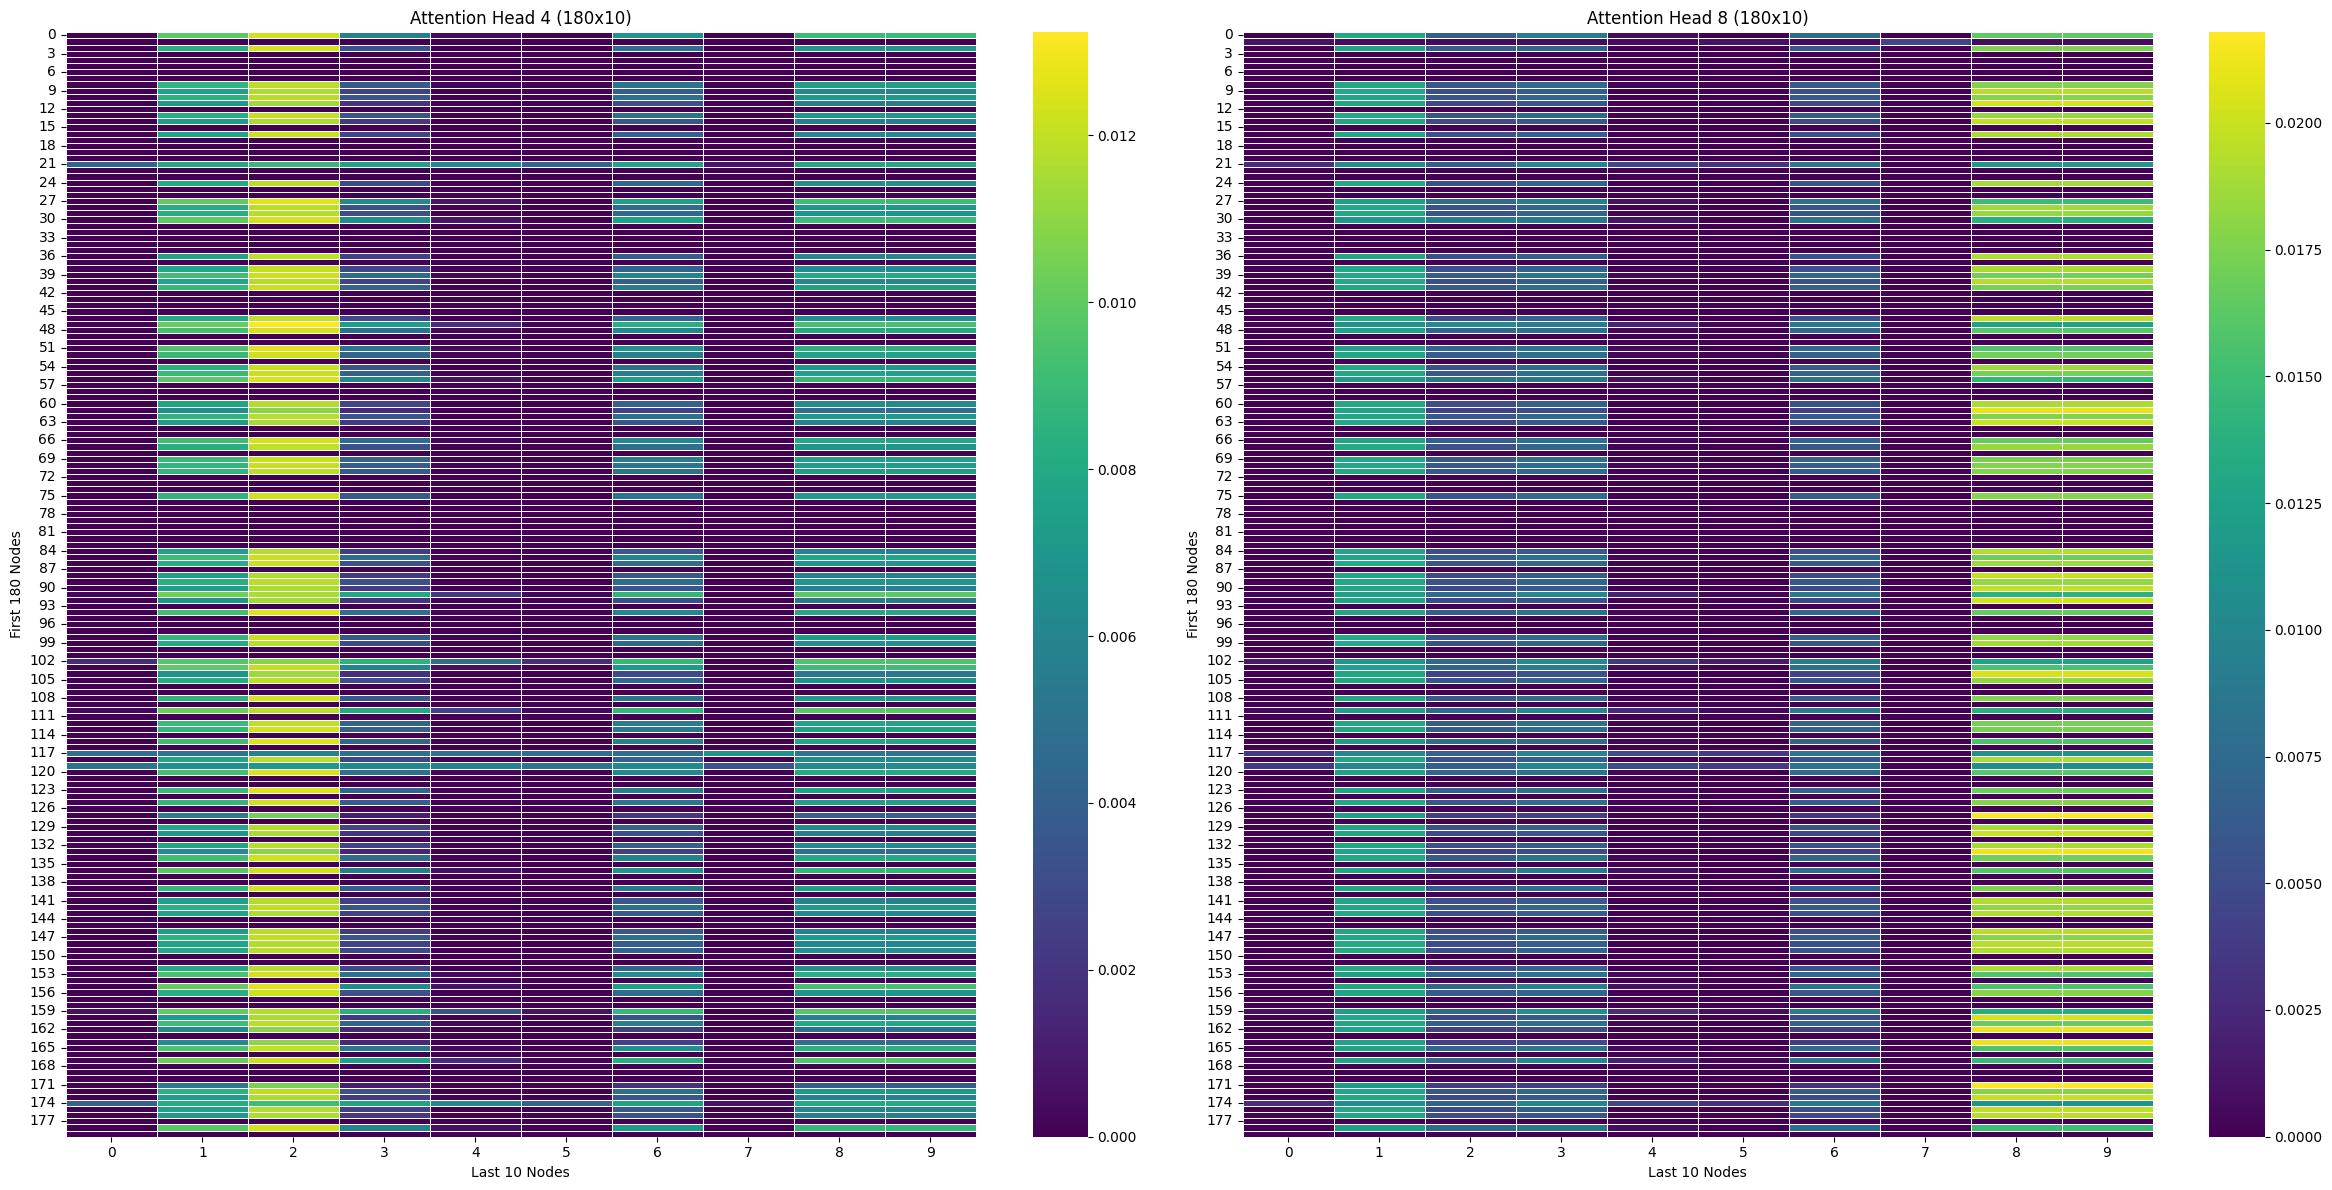

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1x2 grid) with a larger width
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Increase height and width

# Attention head indices we want to plot
head_indices = [3, 7]  # 4th and 8th heads (0-indexed, so 3 and 7)

for i, head_idx in enumerate(head_indices):
    # Extract the attention weights for the selected head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Convert to a DataFrame for easy visualization
    sliced_attention_weights_df = pd.DataFrame(sliced_attention_weights)
    
    # Create the heatmap on the corresponding subplot
    sns.heatmap(sliced_attention_weights_df, cmap='viridis', cbar=True, square=False, ax=axes[i], 
                linewidths=.5)
    
    # Add a title to each subplot
    axes[i].set_title(f'Attention Head {head_idx + 1} (180x10)')
    axes[i].set_xlabel('Last 10 Nodes')
    axes[i].set_ylabel('First 180 Nodes')

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmaps
plt.show()



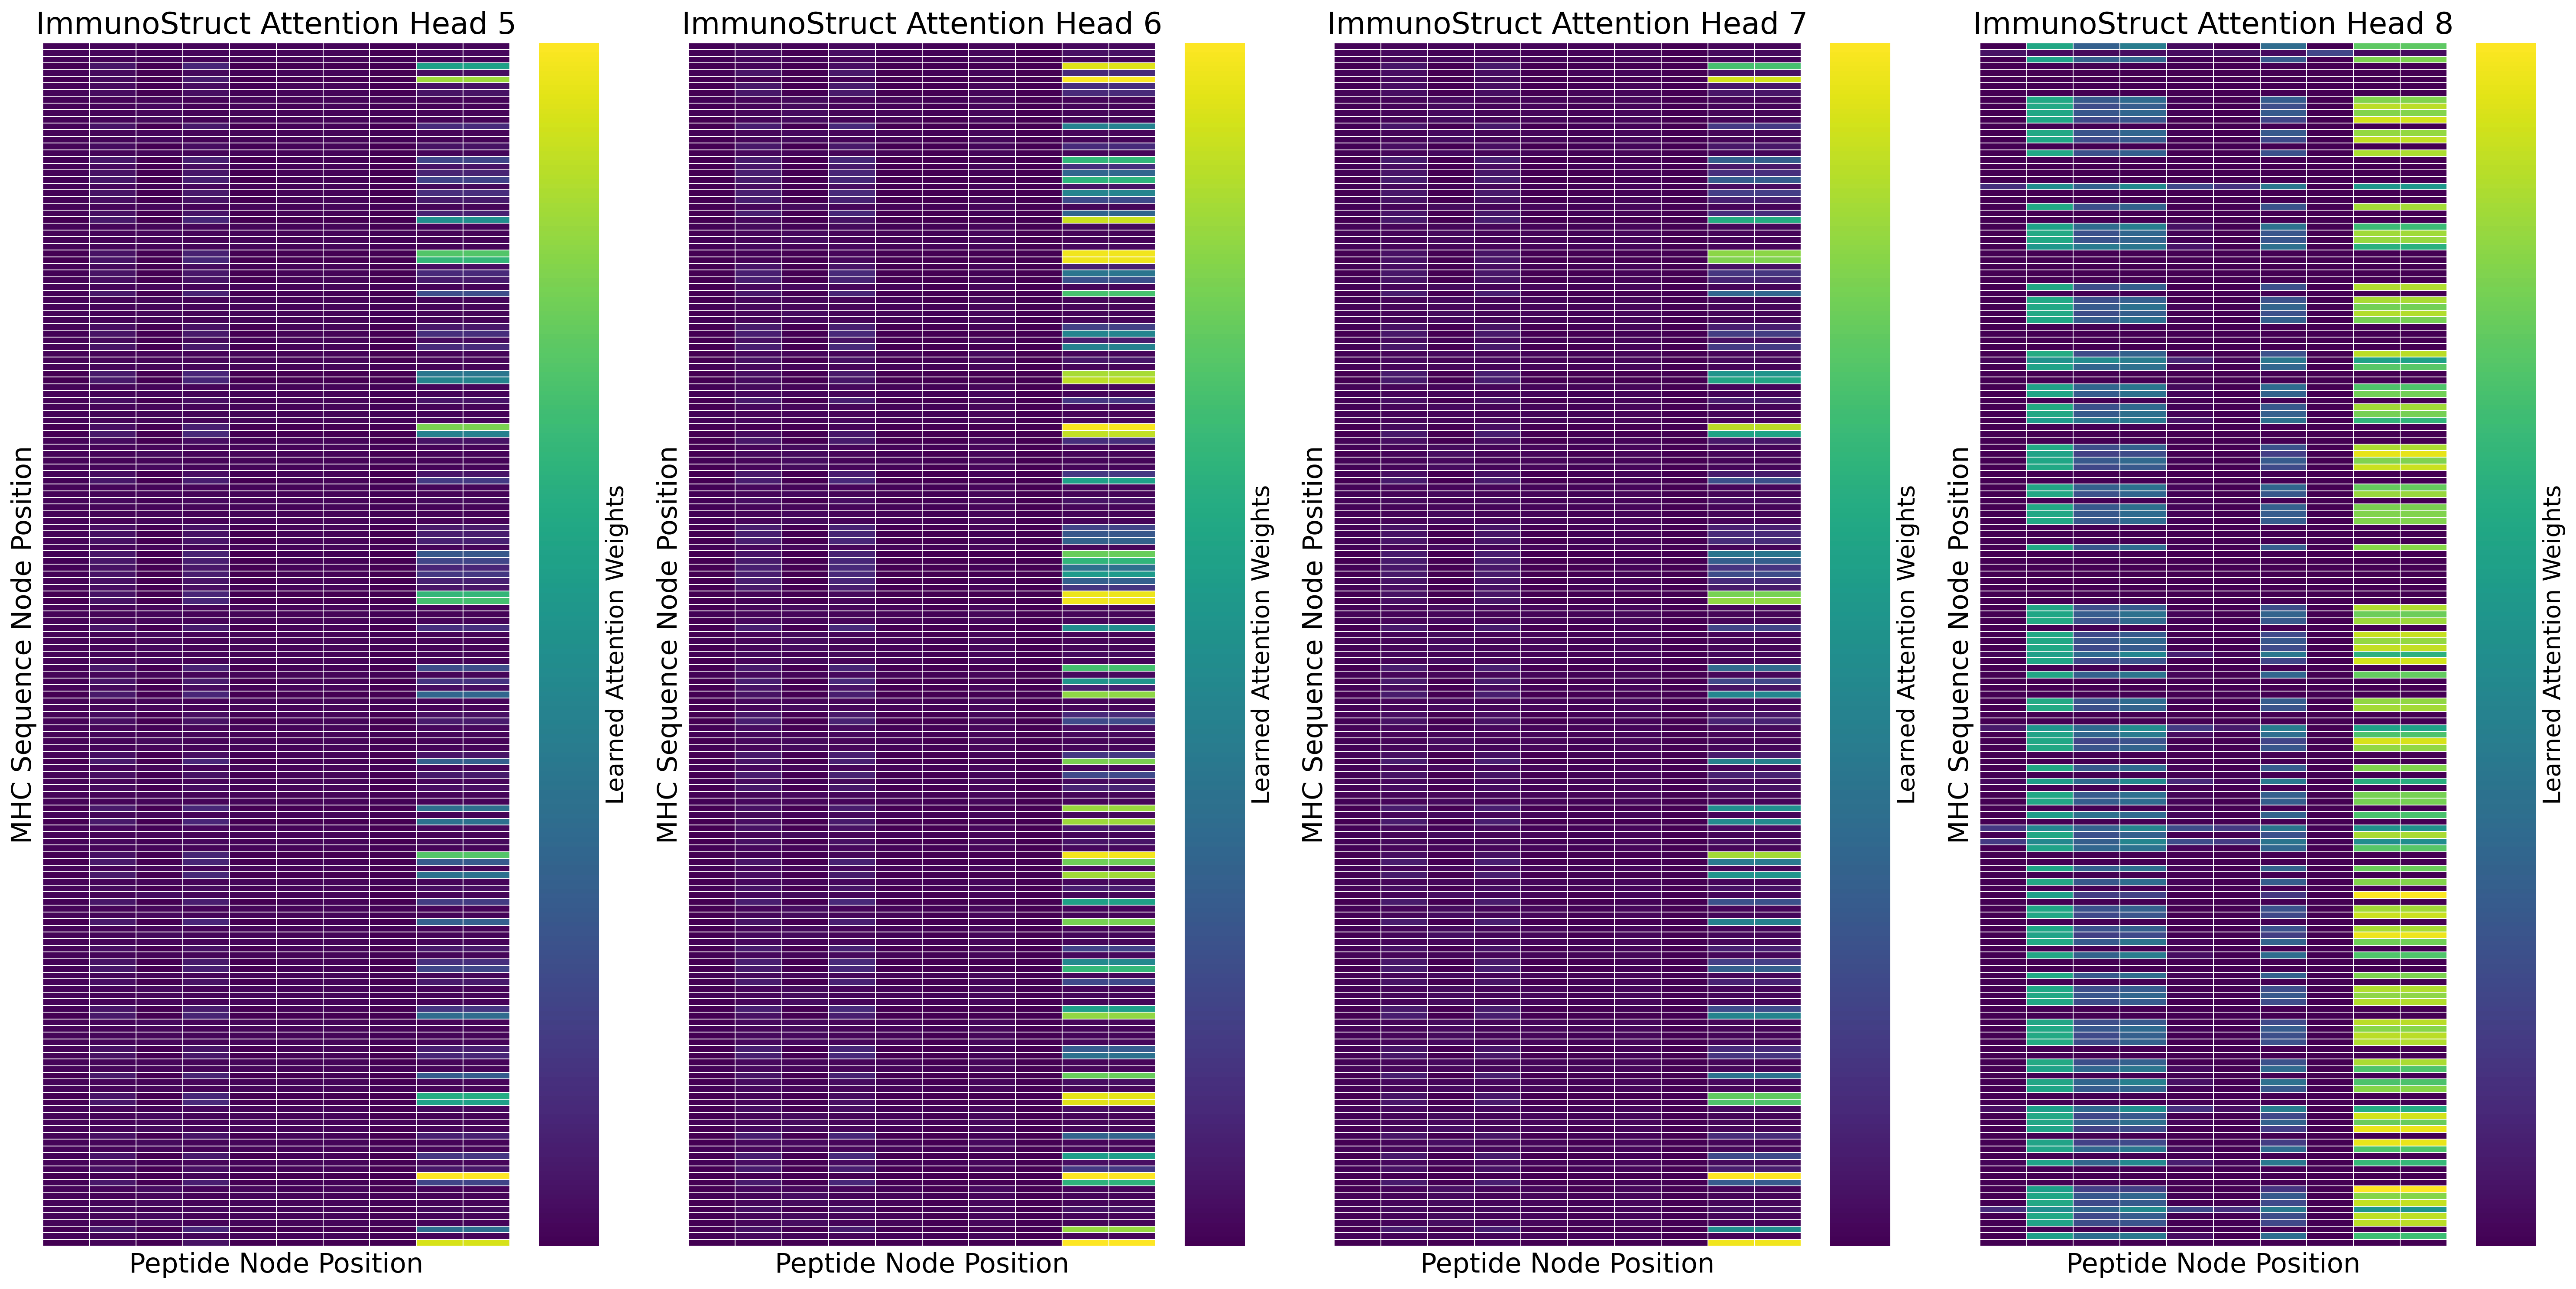

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1x2 grid) with a larger width
fig, axes = plt.subplots(1, 4, figsize=(24, 12), dpi = 250)  # Increase height and width

# Attention head indices we want to plot
head_indices = [4, 5, 6, 7] # 4th and 8th heads (0-indexed, so 3 and 7)

for i, head_idx in enumerate(head_indices):
    # Extract the attention weights for the selected head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Convert to a DataFrame for easy visualization
    sliced_attention_weights_df = pd.DataFrame(sliced_attention_weights)
    
    # Create the heatmap on the corresponding subplot
    heatmap = sns.heatmap(sliced_attention_weights_df, cmap='viridis', cbar=True, square=False, ax=axes[i], 
                          linewidths=.5, xticklabels=False, yticklabels=False)  # Remove the numbers
    
    # Add a title to each subplot with a larger font size
    axes[i].set_title(f'ImmunoStruct Attention Head {head_idx + 1}', fontsize=20)
    
    # Set custom labels
    axes[i].set_xlabel('Peptide Node Position', fontsize=18)
    axes[i].set_ylabel('MHC Sequence Node Position', fontsize=18)
    
    # Label the colorbar
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label('Learned Attention Weights', fontsize=16)
    colorbar.set_ticks([])


# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmaps
plt.show()


In [60]:
import numpy as np

# Initialize a list to store the strongest interactions for each head
strongest_interactions = []

# Iterate over each attention head
for head_idx in range(8):
    # Extract the attention weights for the current head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Find the position of the maximum value in each column (peptide position)
    strongest_interaction_per_column = np.argmax(sliced_attention_weights, axis=0)
    
    # Store the results in a list of tuples (MHC position, Peptide position, Attention Weight)
    for peptide_pos in range(10):
        mhc_pos = strongest_interaction_per_column[peptide_pos]
        attention_weight = sliced_attention_weights[mhc_pos, peptide_pos]
        strongest_interactions.append((head_idx + 1, mhc_pos, peptide_pos + 181, attention_weight))  # Adjusting the peptide position to match the original indices

# Display the strongest interaction for each attention head
for interaction in strongest_interactions:
    head_idx, mhc_pos, peptide_pos, attention_weight = interaction
    print(f'Attention Head {head_idx}: MHC Position {mhc_pos+1} interacts most strongly with Peptide Position {peptide_pos} with weight {attention_weight:.4f}')



Attention Head 1: MHC Position 91 interacts most strongly with Peptide Position 181 with weight 0.0061
Attention Head 1: MHC Position 48 interacts most strongly with Peptide Position 182 with weight 0.0086
Attention Head 1: MHC Position 172 interacts most strongly with Peptide Position 183 with weight 0.0079
Attention Head 1: MHC Position 48 interacts most strongly with Peptide Position 184 with weight 0.0084
Attention Head 1: MHC Position 128 interacts most strongly with Peptide Position 185 with weight 0.0089
Attention Head 1: MHC Position 76 interacts most strongly with Peptide Position 186 with weight 0.0055
Attention Head 1: MHC Position 48 interacts most strongly with Peptide Position 187 with weight 0.0085
Attention Head 1: MHC Position 63 interacts most strongly with Peptide Position 188 with weight 0.0106
Attention Head 1: MHC Position 48 interacts most strongly with Peptide Position 189 with weight 0.0080
Attention Head 1: MHC Position 48 interacts most strongly with Peptide 

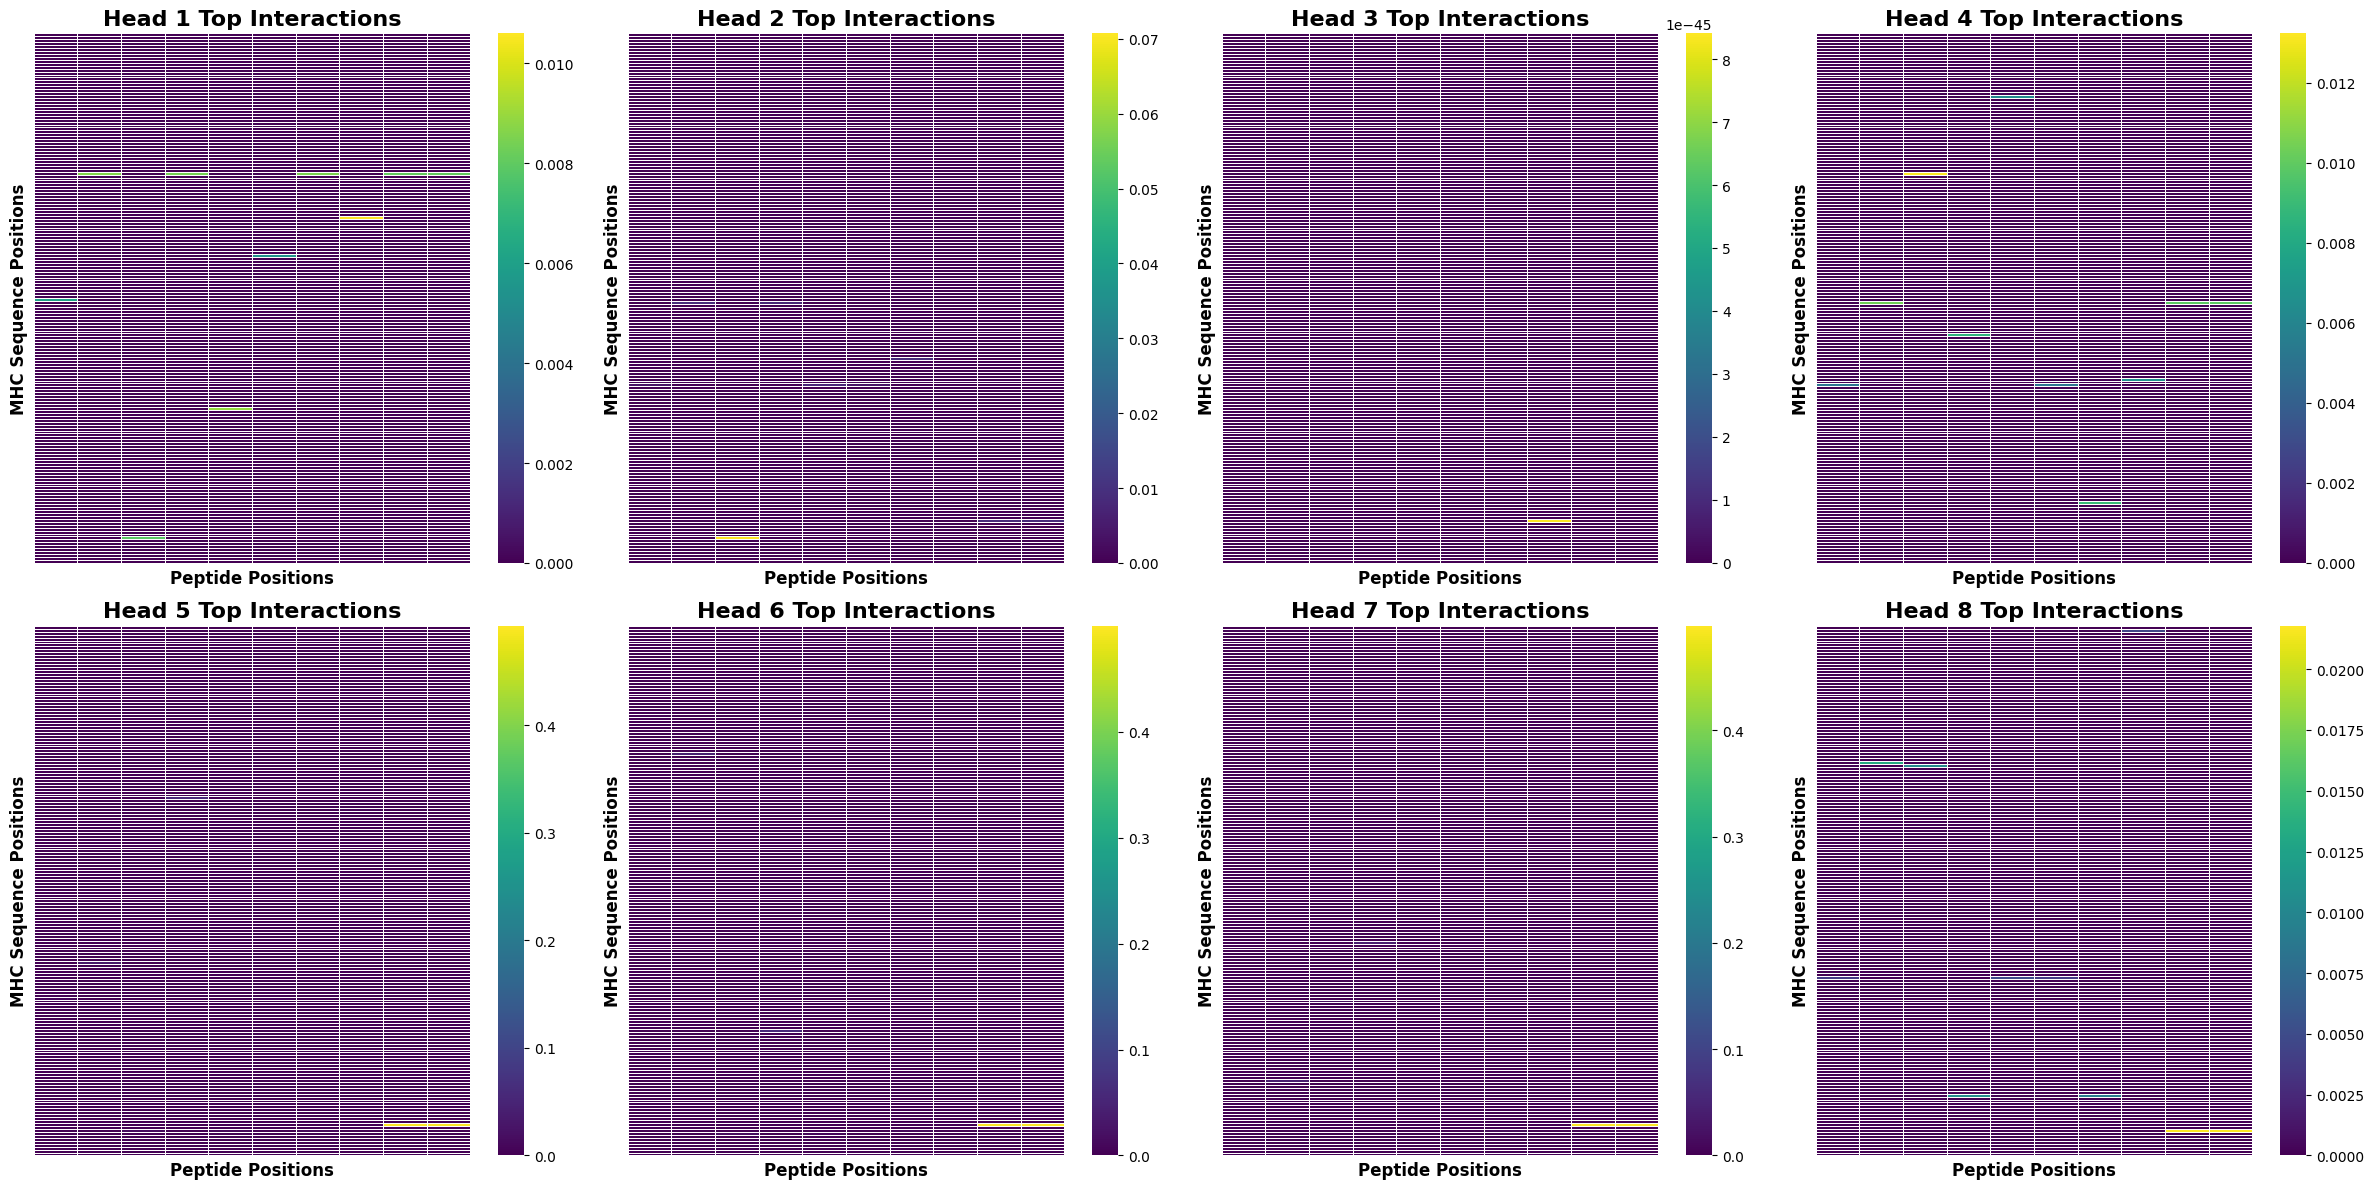

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2x4 subplots to accommodate 8 heatmaps
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each attention head
for head_idx in range(8):
    # Extract the attention weights for the current head
    individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
    
    # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
    sliced_attention_weights = individual_attention_weights[:180, -10:]
    
    # Create an array to store only the strongest interactions
    top_interactions = np.zeros_like(sliced_attention_weights)
    
    # Find the position of the maximum value in each column (peptide position)
    strongest_interaction_per_column = np.argmax(sliced_attention_weights, axis=0)
    
    # Populate the top_interactions array with the strongest interactions
    for peptide_pos in range(10):
        mhc_pos = strongest_interaction_per_column[peptide_pos]
        top_interactions[mhc_pos, peptide_pos] = sliced_attention_weights[mhc_pos, peptide_pos]
    
    # Convert to a DataFrame for easy visualization
    top_interactions_df = pd.DataFrame(top_interactions)
    
    # Create the heatmap on the corresponding subplot
    sns.heatmap(top_interactions_df, cmap='viridis', cbar=True, square=False, ax=axes[head_idx], 
                linewidths=.5, xticklabels=False, yticklabels=False)
    
    # Add a title to each subplot with a larger font size
    axes[head_idx].set_title(f'Head {head_idx + 1} Top Interactions', fontsize=16, fontweight='bold')
    
    # Set custom labels
    axes[head_idx].set_xlabel('Peptide Positions', fontsize=12, fontweight='bold')
    axes[head_idx].set_ylabel('MHC Sequence Positions', fontsize=12, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmaps
plt.show()


In [66]:
import numpy as np

# Initialize a list to store the strongest interaction across all heads for each peptide position
max_interactions_across_heads = []

# Iterate over each peptide position (last 10 positions)
for peptide_pos in range(10):
    max_interaction_value = -np.inf
    best_mhc_pos = None
    best_head_idx = None
    
    # Iterate over each attention head
    for head_idx in range(8):
        # Extract the attention weights for the current head
        individual_attention_weights = attention_weights_list[0][0][head_idx].cpu().numpy()
        
        # Slice the matrix to get the attention weights between the last 10 nodes and the first 180 nodes
        sliced_attention_weights = individual_attention_weights[:180, -10:]
        
        # Find the strongest interaction for this peptide position
        mhc_pos = np.argmax(sliced_attention_weights[:, peptide_pos])
        interaction_value = sliced_attention_weights[mhc_pos, peptide_pos]
        
        # Update the maximum interaction if this one is stronger
        if interaction_value > max_interaction_value:
            max_interaction_value = interaction_value
            best_mhc_pos = mhc_pos
            best_head_idx = head_idx + 1  # Convert to 1-indexed for clarity

    # Store the result for this peptide position
    max_interactions_across_heads.append((best_head_idx, best_mhc_pos + 1, peptide_pos + 181, max_interaction_value))  # Adjust indices for clarity

# Display the maximum interaction for each peptide position across all heads
for interaction in max_interactions_across_heads:
    head_idx, mhc_pos, peptide_pos, interaction_value = interaction
    print(f'Peptide Position {peptide_pos}: MHC Position {mhc_pos} has the strongest interaction in Head {head_idx} with weight {interaction_value:.4f}')


Peptide Position 181: MHC Position 91 has the strongest interaction in Head 1 with weight 0.0061
Peptide Position 182: MHC Position 44 has the strongest interaction in Head 6 with weight 0.0428
Peptide Position 183: MHC Position 172 has the strongest interaction in Head 2 with weight 0.0707
Peptide Position 184: MHC Position 138 has the strongest interaction in Head 6 with weight 0.0578
Peptide Position 185: MHC Position 128 has the strongest interaction in Head 1 with weight 0.0089
Peptide Position 186: MHC Position 127 has the strongest interaction in Head 5 with weight 0.0066
Peptide Position 187: MHC Position 172 has the strongest interaction in Head 6 with weight 0.0098
Peptide Position 188: MHC Position 63 has the strongest interaction in Head 1 with weight 0.0106
Peptide Position 189: MHC Position 170 has the strongest interaction in Head 6 with weight 0.4999
Peptide Position 190: MHC Position 170 has the strongest interaction in Head 6 with weight 0.4999


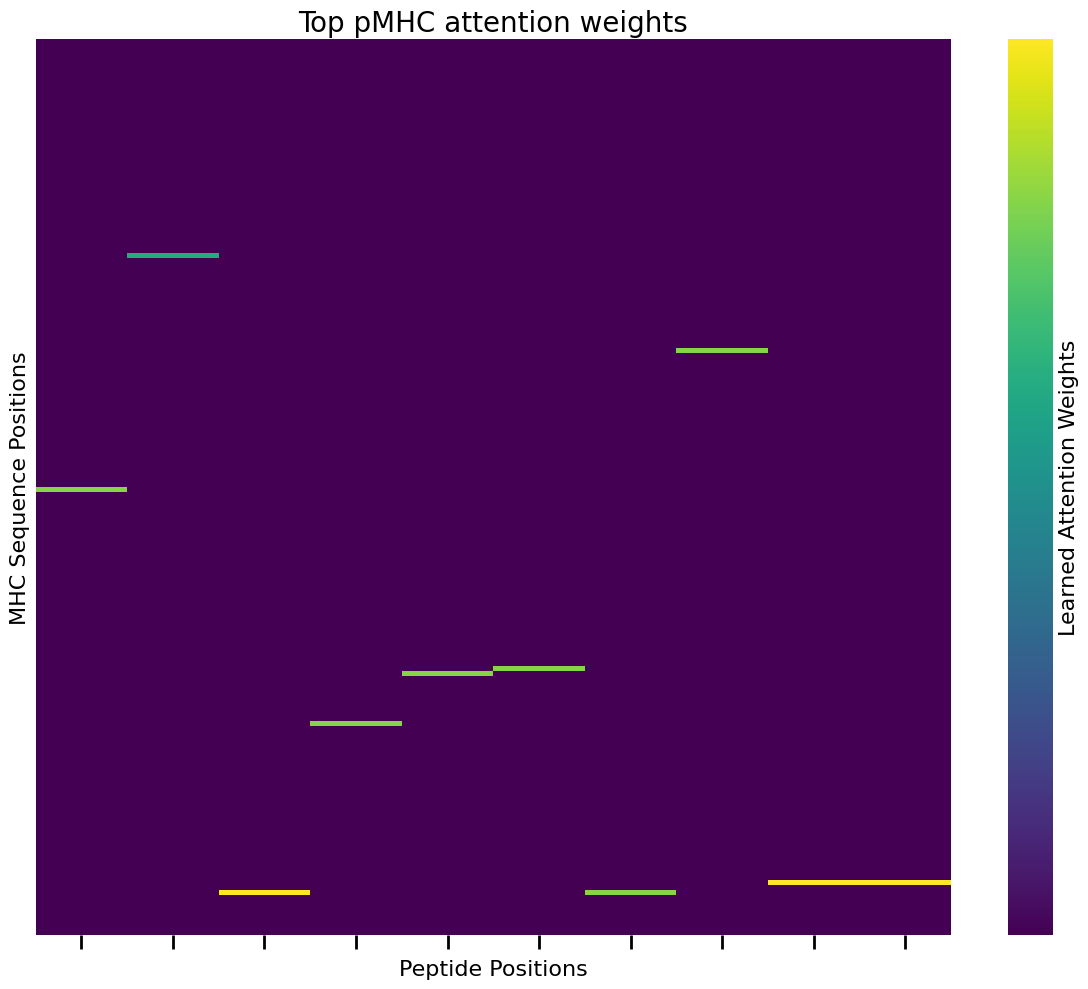

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize an array to store the specific interactions (180x10 matrix)
specific_interactions = np.zeros((180, 10))

# Define the specific interactions
interactions = [
    (91, 181, 0.0578),  # (MHC Position, Peptide Position, Interaction Weight)
    (44, 182, 0.0428),
    (172, 183, 0.0707),
    (138, 184, 0.0578),
    (128, 185, 0.0578),
    (127, 186, 0.0578),
    (172, 187, 0.0578),
    (63, 188, 0.0578),
    (170, 189, 0.0707),
    (170, 190, 0.0707)
]

# Populate the specific_interactions array with the given interactions
for mhc_pos, peptide_pos, interaction_value in interactions:
    specific_interactions[mhc_pos - 1, peptide_pos - 181] = interaction_value  # Adjust indices to 0-indexing

# Convert to a DataFrame for easy visualization
specific_interactions_df = pd.DataFrame(specific_interactions)

# Create the heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(specific_interactions_df, cmap='viridis', cbar=True, square=False, 
                      linewidths=0, xticklabels=False, yticklabels=False)

# Add a title with a larger font size
plt.title('Top pMHC attention weights', fontsize=20)

# Set custom labels
plt.xlabel('Peptide Positions', fontsize=16)
plt.ylabel('MHC Sequence Positions', fontsize=16)
# Add X-tick marks without labels
plt.xticks(ticks=np.arange(10) + 0.5, labels=[])
# Adjust the size and visibility of the ticks
plt.tick_params(axis='x', which='both', length=10, width=2)  # Increase the length and width of the ticks

# Label the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Learned Attention Weights', fontsize=16)
colorbar.set_ticks([])

# Display the heatmap
plt.tight_layout()
plt.show()

